In [8]:
import numpy as np
import pandas as pd
import pickle
import random
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('../../../../../Sharedfolder/Ndata.merged.anonymized.single.relabeled.csv', encoding = "ISO-8859-1")
df = df.dropna(subset=["illicit"])

In [9]:
df = df.dropna(subset=['FOB.VALUE'])

Text(0, 0.5, '# of transactions (pdf)')

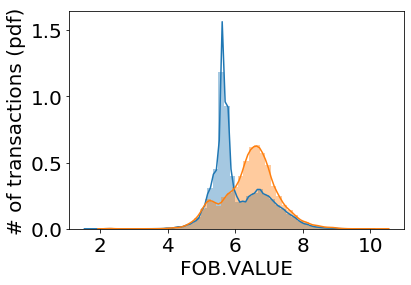

In [12]:
import seaborn as sns
sns.distplot(df[df.illicit == 0]['FOB.VALUE'].apply(np.log10))
sns.distplot(df[df.illicit == 1]['FOB.VALUE'].apply(np.log10))
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('FOB.VALUE', fontsize=20)
plt.ylabel('# of transactions (pdf)', fontsize=20)

In [3]:
df.columns

Index(['YEAR', 'OFFICE', 'SGD.NUMBER', 'SGD.DATE', 'RECEIPT.NUMBER',
       'RECEIPT.DATE', 'IMPORTER.TIN', 'DECLARANT.CODE', 'FOB.VALUE',
       'CIF.VALUE', 'TARIFF.CODE', 'TARIFF.DESCRIPTION', 'QUANTITY',
       'TOTAL.TAXES', 'GROSS.WEIGHT', 'INSPECTION.INFORMATION',
       'SELECTIVITY.LANE', 'EXCHANGERATE', 'CIF_USD_EQUIVALENT', 'illicit',
       'ISO3', 'RAISED_TAX_AMOUNT'],
      dtype='object')

In [4]:
stats = df.groupby(['illicit'])['FOB.VALUE'].apply(np.mean)
print(stats)
stats[0] / stats[1], stats[1] / stats[0]

illicit
0    9.386096e+06
1    1.559226e+07
Name: FOB.VALUE, dtype: float64


(0.6019714969711725, 1.6612082217040394)

In [5]:
stats = df.groupby(['illicit'])['CIF.VALUE'].apply(np.mean)
print(stats)
stats[0] / stats[1]

illicit
0    1.078793e+07
1    1.802776e+07
Name: CIF.VALUE, dtype: float64


0.5984067736760245

In [6]:
stats = df.groupby(['illicit'])['TOTAL.TAXES'].apply(np.mean)
print(stats)
stats[0] / stats[1]

illicit
0    1.564607e+06
1    2.548458e+06
Name: TOTAL.TAXES, dtype: float64


0.6139427926597609

In [13]:
def noiseby10percent(df, transaction_rate, noise_proportion):
    indices = np.random.choice(len(df), int(len(df)*transaction_rate), replace=False)
    before = np.sum(df.loc[indices, 'CIF.VALUE'])
    df.loc[indices, 'CIF.VALUE'] = df.loc[indices, 'CIF.VALUE'] * noise_proportion
    df.loc[indices, 'FOB.VALUE'] = df.loc[indices, 'FOB.VALUE'] * noise_proportion
    df.loc[indices, 'TOTAL.TAXES'] = df.loc[indices, 'TOTAL.TAXES'] * noise_proportion
    after = np.sum(df.loc[indices, 'CIF.VALUE'])
    print(before, after)
    return df

def adjust_illicit_val_deterministic(df, roll_back_constant):
    indices = list(df[df['illicit'] == 1].index)
    before = np.sum(df.loc[indices, 'CIF.VALUE'])
    df.loc[indices, 'CIF.VALUE'] = df.loc[indices, 'CIF.VALUE'] * roll_back_constant
    df.loc[indices, 'FOB.VALUE'] = df.loc[indices, 'FOB.VALUE'] * roll_back_constant
    df.loc[indices, 'TOTAL.TAXES'] = df.loc[indices, 'TOTAL.TAXES'] * roll_back_constant
    after = np.sum(df.loc[indices, 'CIF.VALUE'])
    print(before, after)
    return df

def adjust_illicit_val_stochastic(df, roll_back_constant):
    indices = list(df[df['illicit'] == 1].index)
    before = np.sum(df.loc[indices, 'CIF.VALUE'])
    roll_back_proportion = np.random.normal(loc=roll_back_constant, scale=0.1, size=len(df.loc[indices, 'CIF.VALUE']))
    df.loc[indices, 'CIF.VALUE'] = df.loc[indices, 'CIF.VALUE'] * roll_back_proportion
    df.loc[indices, 'FOB.VALUE'] = df.loc[indices, 'FOB.VALUE'] * roll_back_proportion
    df.loc[indices, 'TOTAL.TAXES'] = df.loc[indices, 'TOTAL.TAXES'] * roll_back_proportion
    after = np.sum(df.loc[indices, 'CIF.VALUE'])
    print(before, after)
    return df

In [10]:
import pickle

for method in ['rollback-stochastic', 'rollback-deterministic']:
    
    df = pd.read_csv('../../../../../Sharedfolder/Ndata.merged.anonymized.single.relabeled.csv', encoding = "ISO-8859-1")
    df = df.dropna(subset=["illicit"])
    
    stats = df.groupby(['illicit'])['CIF.VALUE'].apply(np.mean)
    roll_back_constant = stats[0] / stats[1]
        
    if method == 'rollback-stochastic':
        df = adjust_illicit_val_stochastic(df, roll_back_constant)
        print(method, df.groupby(['illicit'])['CIF.VALUE'].apply(np.mean))
    if method == 'rollback-deterministic':
        df = adjust_illicit_val_deterministic(df, roll_back_constant)
        print(method, df.groupby(['illicit'])['CIF.VALUE'].apply(np.mean))
    
    file_path = f'./data/Ndata.merged.anonymized.single.relabeled.{method}.p'
    df.to_pickle(file_path)
    
    df = pd.read_pickle(file_path)
    print(method, df.groupby(['illicit'])['CIF.VALUE'].apply(np.mean))

1339156077187.0 800280703022.63
rollback-stochastic illicit
0    1.078793e+07
1    1.077340e+07
Name: CIF.VALUE, dtype: float64
rollback-stochastic illicit
0    1.078793e+07
1    1.077340e+07
Name: CIF.VALUE, dtype: float64
1339156077187.0 801360067598.1139
rollback-deterministic illicit
0    1.078793e+07
1    1.078793e+07
Name: CIF.VALUE, dtype: float64
rollback-deterministic illicit
0    1.078793e+07
1    1.078793e+07
Name: CIF.VALUE, dtype: float64


In [20]:
df = pd.read_pickle('./data/Ndata.merged.anonymized.single.relabeled.rollback-stochastic.p')

In [21]:
df = df.dropna(subset=['FOB.VALUE'])

Text(0, 0.5, '# of transactions (pdf)')

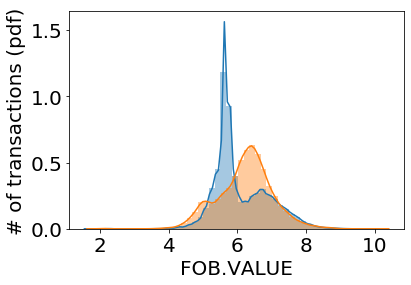

In [31]:
import seaborn as sns
sns.distplot(df[df.illicit == 0]['FOB.VALUE'].apply(np.log10))
sns.distplot(df[df.illicit == 1]['FOB.VALUE'].apply(np.log10))
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('FOB.VALUE', fontsize=20)
plt.ylabel('# of transactions (pdf)', fontsize=20)

In [30]:
df.groupby(['illicit'])['FOB.VALUE'].apply(np.mean)


illicit
0    9.386096e+06
1    9.318851e+06
Name: FOB.VALUE, dtype: float64